In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
senti = pd.read_json("../graph_network/full_data_iv_29-04-24.json")
s = pd.read_json("../sentiment-analyser/saiv_28-04-24.json") 
# s = s.drop_duplicates(subset=['text', "negative", "neutral", "positive"])

pd.set_option('display.max_colwidth', None)

In [3]:
senti.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages'],
      dtype='object')

In [2]:

senti[senti["url"]=="https://www.mobiliar.ch/versicherungen-und-vorsorge/services/schaden-melden"]

,url,pagetitle,negative,neutral,positive,color,text,linkedpages
30,https://www.mobiliar.ch/versicherungen-und-vorsorge/services/schaden-melden,Schaden melden,0.844019,0.061671,0.09431,#e62700,Schaden melden Ist Ihnen trotz aller Sorgfalt ein Schaden passiert? Dann helfen wir Ihnen rasch und unkompliziert. Die Mobiliar in Ihrer Nähe Möchten Sie Ihren Schaden persönlich besprechen? Die Generalagentur in Ihrer Nähe ist gern für Sie da. Agentur finden Kontakt aufnehmen,"[https://www.mobiliar.ch/, https://www.mobiliar.ch/versicherungen-und-vorsorge/services, https://secure.mobiliar.ch/mcs-osm-b2c/public/, https://secure.protekta.ch/mcs-osm-b2c/protekta/public/, https://osm.apps.mobiliar.ch/node/62/, https://www.mobiliar.ch/versicherungen-und-vorsorge/generalagenturen, https://www.mobiliar.ch/kontaktaufnahme]"


In [14]:
def save_as_json(pandas_dataframe, file_name):
    import datetime
    date_info = datetime.datetime.now().strftime("%d-%m-%y")
    pandas_dataframe.to_json(f"{file_name}_{date_info}.json", orient='records')


def get_mean_coefficients_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    for i in range(df[cluster_col].unique().shape[0]):
        count = df.loc[df[cluster_col]==i].shape[0]
        print(f"Cluster Nr. {i}; Total Pages in Cluster: {count}")
        for coeff in coefficient_names:
            print(f"avg {coeff}:", round(df.loc[df[cluster_col]==i, coeff].mean(), 5))
        print()

def append_mean_coefficients_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    mean_coeffs = df.groupby(cluster_col)[coefficient_names].mean().reset_index()
    mean_coeffs.rename(columns={name: f"avg_{cluster_col[:-3]}_{name[:3]}" for name in coefficient_names}, inplace=True)
    df = pd.merge(df, mean_coeffs, on=cluster_col, how='left')
    
    return df
        

def get_color(input_vector):
    import numpy as np
    red = np.array([1, 0, 0])
    yellow = np.array([1, 1, 0])
    green = np.array([0, 1, 0])
    rgb = input_vector[0] * red + input_vector[1] * yellow + input_vector[2] * green
    color = "#" + "".join(f"{int(x*255):02x}" for x in rgb)
    return color


def add_color_column_of_df_to_matrix(dataframe, cluster_column, new_col_names):
    dataframe[f"color_{cluster_column}"] = (
        dataframe[new_col_names]
        .apply(lambda row: np.array(row), axis=1)
        .apply(lambda row: get_color(row))
    )
    # result = pd.merge(matrix, dataframe[["url", "color"]], how="left", on=["url"])
    return dataframe

def get_cluster_average_color(df, cluster_column, columns_to_average):
    new_col_names=[]
    for col in columns_to_average:
        average_col_name = f"m_{col}"  # Erzeuge Namen für die neuen Durchschnittsspalten
        df[average_col_name] = df.groupby(cluster_column)[col].transform('mean')
        new_col_names.append(average_col_name)
    df = add_color_column_of_df_to_matrix(df, cluster_column, new_col_names)
    for average_col_name in new_col_names:
        df.drop(average_col_name, axis=1, inplace=True)
    return df

def get_mean_sentiment_coefficients_of_neighbours(pandas_dataframe):
    coefficient_names = ["negative", "neutral", "positive"]
    for coefficient in coefficient_names:
        results = []
        result_dataframe = pandas_dataframe
        all_urls = pandas_dataframe.url.tolist()
        for url in all_urls:
            idx = all_urls.index(url)
            linkedpages_per_url = pandas_dataframe.at[idx, "linkedpages"]
            mean_of_neighbours = pandas_dataframe.loc[pandas_dataframe["url"].isin(linkedpages_per_url), coefficient].mean()
            results.append(round(mean_of_neighbours, 5))
        pandas_dataframe.insert(loc=len(pandas_dataframe.columns), column=f"avg_{coefficient}_of_neighbours", value=results)
    return pandas_dataframe


def append_cluster_color(df, cluster_col):
    cluster_sizes = df[cluster_col].value_counts().sort_values(ascending=False)
    cmap = plt.get_cmap('turbo') #viridis
    num_of_clusters = len(cluster_sizes)
    colors = [cmap(i / num_of_clusters) for i in range(num_of_clusters)]
    color_mapping = {cluster_id: color for cluster_id, color in zip(cluster_sizes.index, colors)}
    df[f'color_{cluster_col}'] = df[cluster_col].apply(lambda x: color_mapping[x])


def get_cluster_plot(pandas_df, cluster_col):
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    color_col = f"color_{cluster_col}"
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(pandas_df['negative'], pandas_df['neutral'], pandas_df['positive'], c=pandas_df[color_col])
    ax.set_xlabel('Negative')
    ax.set_ylabel('Neutral')
    ax.set_zlabel('Positive')
    plt.show()

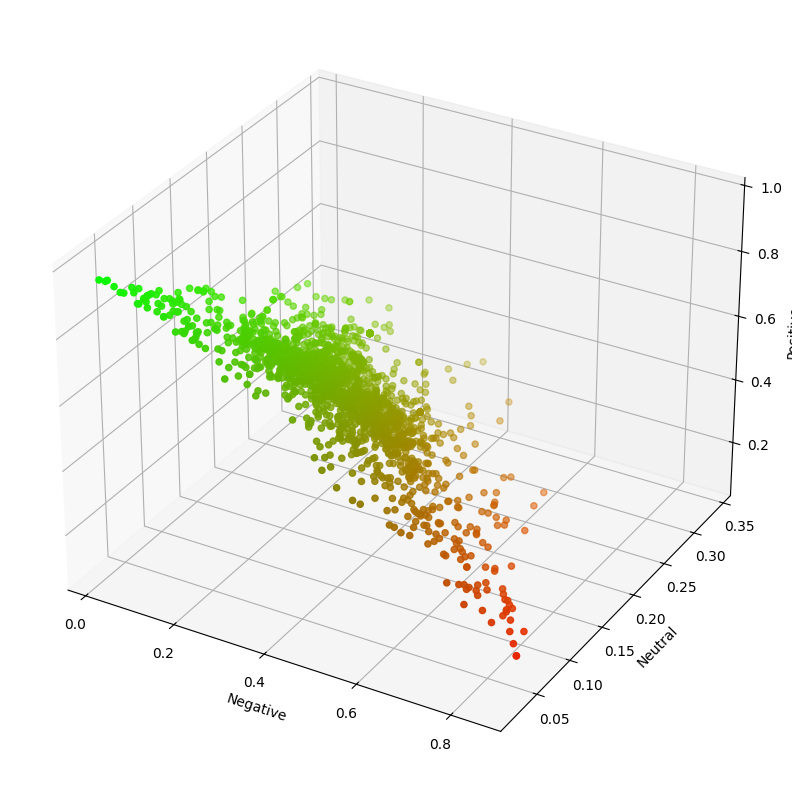

In [10]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Erstellen einer neuen Figur
fig = plt.figure(figsize=(10, 10))

# Hinzufügen eines 3D-Subplots
ax = fig.add_subplot(111, projection='3d')

# Daten für jede Achse
x = senti["negative"]
y = senti["neutral"]
z = senti["positive"]
color = senti["color"]
# Plotten der Daten
ax.scatter3D(x, y, z, c=color)
# Beschriftung der Achsen
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
ax.set_zlabel('Positive')
# Anzeigen des Plots
plt.show()


In [ ]:
# XY-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, y, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Neutral')
plt.title('2D Plot - XY Plane')
plt.show()

# XZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(x, z, c=color)
ax.set_xlabel('Negative')
ax.set_ylabel('Positive')
plt.title('2D Plot - XZ Plane')
plt.show()

# YZ-Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(y, z, c=color)
ax.set_xlabel('Neutral')
ax.set_ylabel('Positive')
plt.title('2D Plot - YZ Plane')
plt.show()


# Clustering
## K-Means

/Users/romanroth/opt/anaconda3/envs/WBTH-Project/lib/python3.10/site-packages/threadpoolctl.py:1223: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


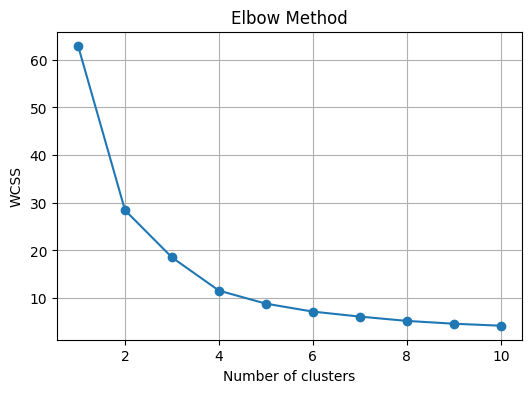

In [11]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):  # Ändern Sie 11 je nach Bedarf für größere k
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(senti[['negative','neutral', 'positive']])
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt

# Erstellen eines Plots
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')  # Passen Sie den Bereich entsprechend an
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [12]:
import pandas as pd
from sklearn.cluster import KMeans

# Angenommen, df ist Ihr DataFrame und enthält die Spalten 'a', 'b', 'c'
data = senti[['negative','neutral', 'positive']]

# Erstellen des KMeans-Cluster-Modells
# 'n_clusters' ist die Anzahl der Cluster, die Sie möchten (hier z.B. 3)
kmeans = KMeans(n_clusters=5)

# Anpassen des Modells an Ihre Daten
kmeans.fit(data)

# Vorhersage der Cluster-Labels für die Daten
labels = kmeans.labels_

# Hinzufügen der Cluster-Labels zu Ihrem DataFrame
senti['cluster'] = labels

append_cluster_color(senti, "cluster")

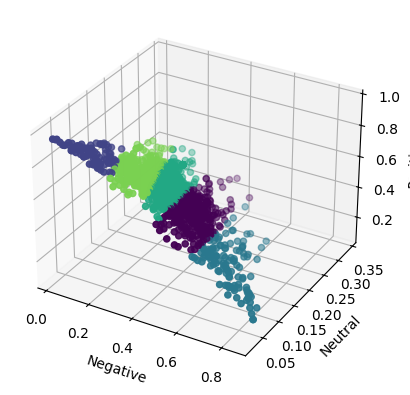

In [13]:
get_cluster_plot(senti, "cluster")

## DB-Scan Clustering

In [14]:
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler


# DataFrame df annehmen, der die entsprechenden Spalten enthält
features = senti[['negative', 'neutral', 'positive']]

# Skalieren der Daten
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [15]:
# DBSCAN-Clustering
dbscan = DBSCAN(eps=0.20, min_samples=5)  # eps und min_samples nach Bedarf anpassen
clusters = dbscan.fit_predict(features_scaled)

# Hinzufügen der Cluster-Labels zum ursprünglichen DataFrame
senti['cluster-db'] = clusters
append_cluster_color(senti, 'cluster-db')

In [214]:
print(senti['cluster-db'].value_counts())

cluster-db
 0     1360
-1      196
 1       67
 4       43
 2       21
 8       11
 3        9
 9        7
 5        6
 7        6
 10       5
 6        5
 12       5
 11       5
Name: count, dtype: int64


In [229]:
senti['color_cluster-db'].nunique()

14

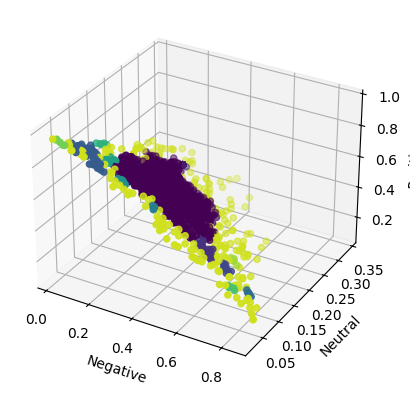

In [16]:
get_cluster_plot(senti, "cluster-db")

## Hierarchical Clustering 

In [17]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
# DataFrame df annehmen, der die entsprechenden Spalten enthält
features = senti[['negative', 'neutral', 'positive']]

# Skalieren der Daten
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

In [18]:
# Hierarchical Clustering
cluster = AgglomerativeClustering(n_clusters=8, linkage='ward')
# Anwenden des Modells
cluster_labels = cluster.fit_predict(features_scaled)

# Hinzufügen der Cluster-Labels zum DataFrame
senti['cluster-h'] = cluster_labels
append_cluster_color(senti, 'cluster-h')

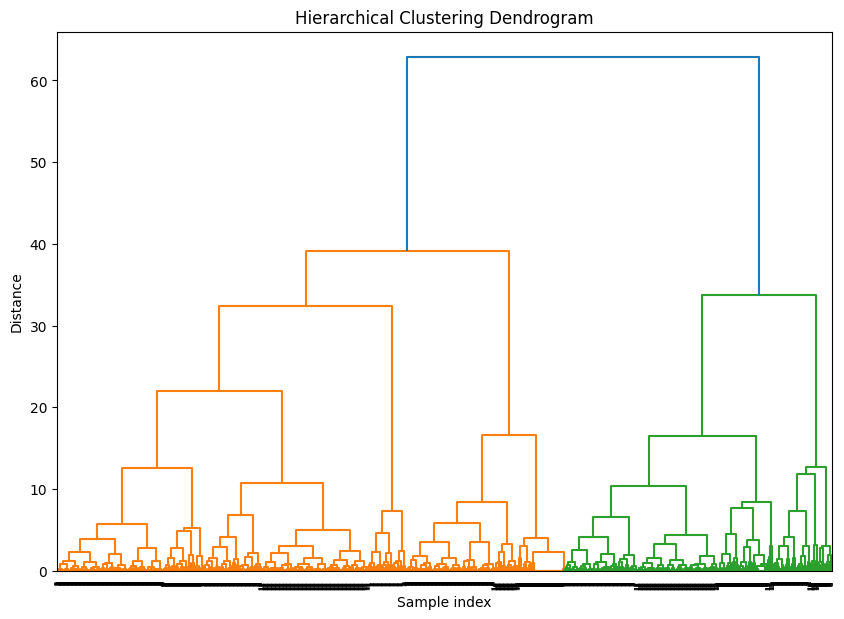

In [78]:
# Erstellen eines Linkage-Matrix
linked = linkage(features_scaled, 'ward')

# Dendrogramm zeichnen
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation='top', labels=cluster_labels, distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample index')
plt.ylabel('Distance')
plt.show()

In [85]:
senti['cluster-h'].value_counts()

cluster-h
5    372
1    346
2    329
7    254
0    133
3    124
6    104
4     84
Name: count, dtype: int64

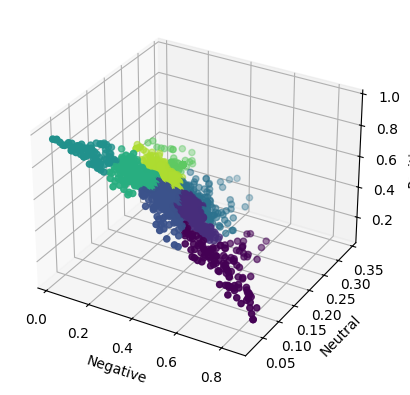

In [19]:
get_cluster_plot(senti, "cluster-h")

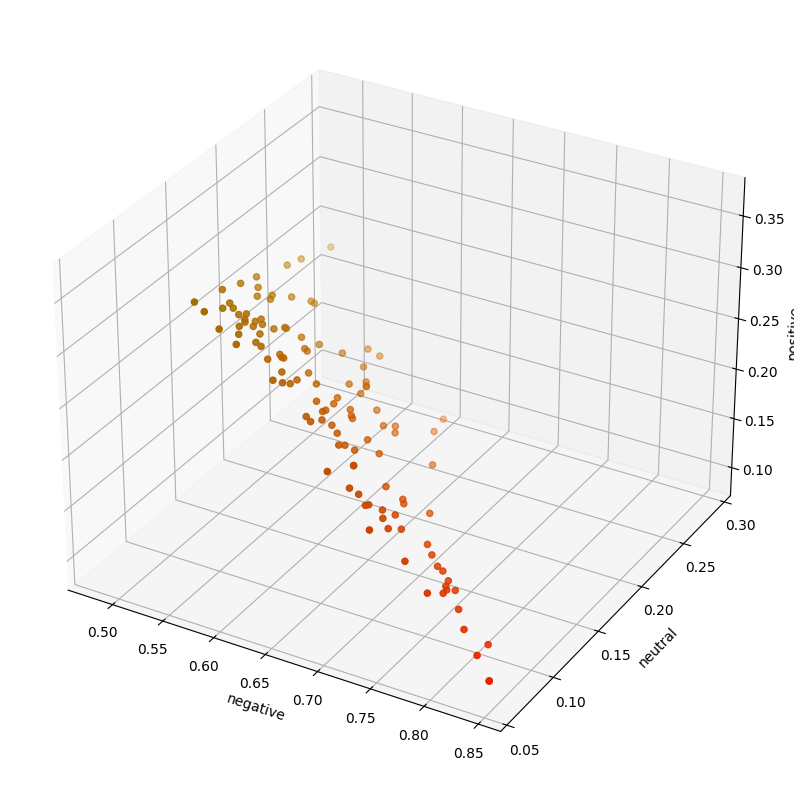

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Erstellen einer neuen Figur
fig = plt.figure(figsize=(15, 10))

# Hinzufügen eines 3D-Subplots
ax = fig.add_subplot(111, projection='3d')

# Daten für jede Achse
df = senti.loc[senti["cluster"]==2]
x = df["negative"]
y = df["neutral"]
z = df["positive"]
color = df["color"]

# Plotten der Daten
ax.scatter3D(x, y, z, c=color)

# Beschriftung der Achsen
ax.set_xlabel('negative')
ax.set_ylabel('neutral')
ax.set_zlabel('positive')

# Anzeigen des Plots
plt.show()

In [21]:
import json

with open("../graph_network/scc_dict.json") as json_file:
    scc_dict = json.load(json_file)
senti['scc_id'] = senti['url'].map(scc_dict)
append_cluster_color(senti, 'scc_id')

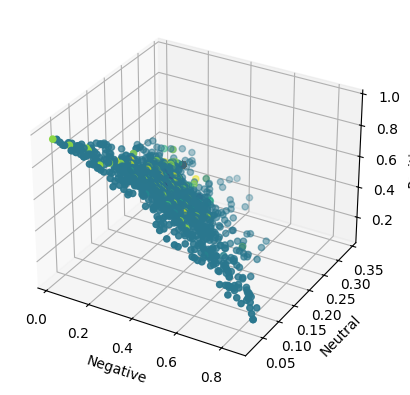

In [22]:
get_cluster_plot(senti, "scc_id")

In [23]:
import json
with open("../graph_network/wcc_dict.json") as json_file:
    wcc_dict = json.load(json_file)
senti['wcc_id'] = senti['url'].map(wcc_dict)
append_cluster_color(senti, 'wcc_id')

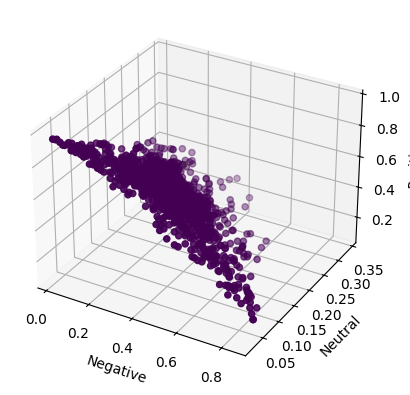

In [24]:
get_cluster_plot(senti, "wcc_id")

In [20]:
graph_clustering_shortest_path.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages', 'cluster_id'],
      dtype='object')

In [19]:
import json
with open("../graph_network/graph_clustering_shortest_path.json") as json_file:
    hier = json.load(json_file)
graph_clustering_shortest_path = senti.copy()
graph_clustering_shortest_path['cluster_id'] = graph_clustering_shortest_path['url'].map(hier)

In [22]:
graph_clustering_shortest_path = graph_clustering_shortest_path.dropna(subset=["cluster_id"])

/var/folders/z3/m0_jmm793c13j56bgg5x44dw0000gn/T/ipykernel_23372/2525594011.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'color_{cluster_col}'] = df[cluster_col].apply(lambda x: color_mapping[x])


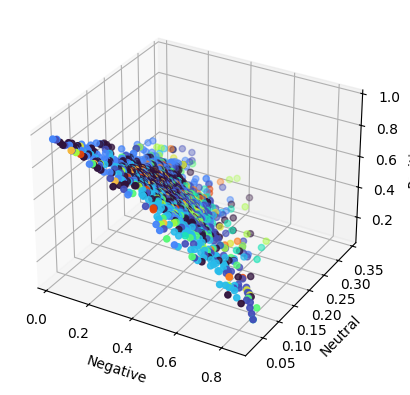

In [24]:
append_cluster_color(graph_clustering_shortest_path, 'cluster_id')
get_cluster_plot(graph_clustering_shortest_path, "cluster_id")

In [27]:
graph_clustering_shortest_path.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages', 'cluster_id', 'color_cluster_id'],
      dtype='object')

In [25]:
import json
with open("../graph_network/louvain_communities_dict.json") as json_file:
    louvain_communities_dict = json.load(json_file)
senti['louvain_id'] = senti['url'].map(louvain_communities_dict)
append_cluster_color(senti, 'louvain_id')

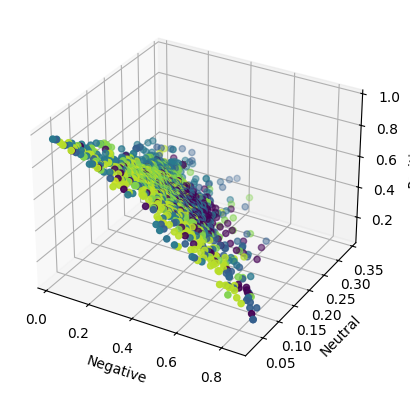

In [26]:
get_cluster_plot(senti, "louvain_id")

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
import nltk
# nltk.download('stopwords')

stop_words = []
with open("../sentiment-analyser/german_stopwords.txt", 'r', encoding='utf-8') as file:
    content = file.read()
    stop_words = [word.strip() for word in content.split(',')]

stop_words = stop_words + ["mobiliar", "z.B.", "jQuery", "getScript", "hasJquery", "function", "undefined", "letTimeout"]


# Erstellen eines TfidfVectorizer-Objekts
vectorizer = TfidfVectorizer(max_features=1000, stop_words=stop_words)

# Anpassen des Vectorizers an die Textdaten und Umwandlung der Textdaten
tfidf_matrix = vectorizer.fit_transform(senti['text'])

/Users/romanroth/opt/anaconda3/envs/WBTH-Project/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['bsp', 'getscript', 'hasjquery', 'jquery', 'lettimeout', 'zb'] not in stop_words.
  warnings.warn(


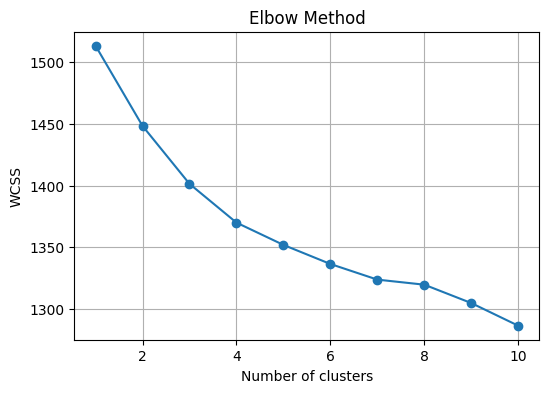

In [29]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):  # Ändern Sie 11 je nach Bedarf für größere k
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(tfidf_matrix)
    wcss.append(kmeans.inertia_)

import matplotlib.pyplot as plt

# Erstellen eines Plots
plt.figure(figsize=(6, 4))
plt.plot(range(1, 11), wcss, marker='o')  # Passen Sie den Bereich entsprechend an
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [30]:
from sklearn.cluster import KMeans

# Erstellen eines KMeans-Modells
num_clusters = 5  # Sie können die Anzahl der Cluster basierend auf Ihrer Analyse festlegen
kmeans = KMeans(n_clusters=num_clusters, random_state=0)

# Anpassen des Modells an die TF-IDF-Matrix
kmeans.fit(tfidf_matrix)

# Zuordnen der Dokumente zu Clustern
clusters = kmeans.labels_
senti['tf-idf_kmeans'] = clusters
append_cluster_color(senti, 'tf-idf_kmeans')


In [ ]:
get_cluster_plot(senti, "tf-idf_kmeans")

In [43]:
save_as_json(senti, "cluster_data")

In [ ]:
bins = np.arange(0, 1.05, 0.05) 
hist, bin_edges = np.histogram(senti['positive'], bins=bins)

# Histogramm anzeigen
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.xlabel('Coeficent')
plt.ylabel('sum of values')
plt.title('Distribution of positive coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['neutral'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of neutral coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

hist, bin_edges = np.histogram(senti['negative'], bins=bins)
plt.figure(figsize=(6, 4))
plt.bar(bins[:-1], hist, width=0.05, align='edge', alpha=0.7)
plt.title('Distribution of negative coeficients')
plt.xticks(np.arange(0, 1.05, 0.1))
plt.grid(True)
plt.show()

# Boxplot erstellen
plt.figure(figsize=(6, 4))
# plt.boxplot(senti['negative'], vert=False)
plt.boxplot([senti['negative'], senti['neutral'], senti['positive']], labels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Negative Rating')
plt.title('Boxplot der negativen Bewertungen')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist([senti['negative'], senti['neutral'], senti['positive']], bins=bins, stacked=True, label=['Negative', 'Neutral', 'Positive'], color=['red', 'yellow', 'green'], alpha=0.5)
plt.xlabel('Bewertungswerte')
plt.ylabel('Häufigkeit')
plt.title('Gestapelte Histogramme der Bewertungen')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
senti = get_mean_sentiment_coefficients_of_neighbours(senti)
senti.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages', 'avg_negative', 'avg_neutral', 'avg_positive',
       'avg_negative_of_neighbour', 'avg_neutral_of_neighbour',
       'avg_positive_of_neighbour', 'avg_negative_of_neighbours',
       'avg_neutral_of_neighbours', 'avg_positive_of_neighbours'],
      dtype='object')

In [16]:
senti[['negative','neutral','positive','avg_negative_of_neighbours','avg_neutral_of_neighbours','avg_positive_of_neighbours']].corr(method="pearson")[["negative", "neutral", "positive"]][3:6]

,negative,neutral,positive
avg_negative_of_neighbours,0.084523,-0.052226,-0.062588
avg_neutral_of_neighbours,-0.065424,0.242241,-0.012845
avg_positive_of_neighbours,-0.035171,-0.080587,0.057117


In [41]:
senti.corr(method='pearson', numeric_only = True)

,negative,neutral,positive,cluster,cluster-db,cluster-h,scc_id,wcc_id,louvain_id,tf-idf_kmeans,avg_negative,avg_neutral,avg_positive
negative,1.000000,0.023083,-0.943124,-0.508870,-0.125000,-0.721265,-0.064162,-0.070544,-0.223734,0.029060,0.084523,-0.065424,-0.035171
neutral,0.023083,1.000000,-0.354122,-0.044132,-0.286193,0.246753,0.018132,0.228675,-0.285252,0.176083,-0.052226,0.242241,-0.080587
positive,-0.943124,-0.354122,1.000000,0.490697,0.212099,0.592653,0.053991,-0.010051,0.304146,-0.085737,-0.062588,-0.012845,0.057117
cluster,-0.508870,-0.044132,0.490697,1.000000,-0.066725,0.639383,0.016797,0.055160,0.347168,-0.178707,0.006853,0.049653,-0.030739
cluster-db,-0.125000,-0.286193,0.212099,-0.066725,1.000000,-0.016404,0.005136,0.047375,0.028744,0.042546,-0.053395,-0.084243,0.085901
cluster-h,-0.721265,0.246753,0.592653,0.639383,-0.016404,1.000000,0.050845,0.125226,0.202391,-0.011947,-0.073391,0.104228,0.006493
scc_id,-0.064162,0.018132,0.053991,0.016797,0.005136,0.050845,1.000000,0.393086,0.028573,0.073451,-0.130628,0.013758,0.098681
wcc_id,-0.070544,0.228675,-0.010051,0.055160,0.047375,0.125226,0.393086,1.000000,0.037551,0.050921,NaN,NaN,NaN
louvain_id,-0.223734,-0.285252,0.304146,0.347168,0.028744,0.202391,0.028573,0.037551,1.000000,-0.411883,0.119353,-0.125874,-0.032739
tf-idf_kmeans,0.029060,0.176083,-0.085737,-0.178707,0.042546,-0.011947,0.073451,0.050921,-0.411883,1.000000,-0.234723,-0.033076,0.206634


<Figure size 1000x800 with 0 Axes>

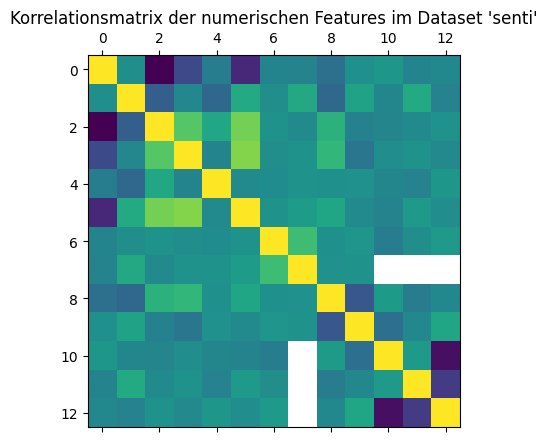

In [42]:

import matplotlib.pyplot as plt
# Heatmap der Korrelationsmatrix erstellen
plt.figure(figsize=(10, 8))
plt.matshow(senti.corr(method='pearson', numeric_only = True))
plt.title("Korrelationsmatrix der numerischen Features im Dataset 'senti'")
plt.show()


In [89]:
cluster = senti.groupby("cluster")
cluster.describe().head()

negative                                                              \
           count      mean       std       min       25%       50%       75%   
cluster                                                                        
0          419.0  0.234782  0.035903  0.131020  0.212159  0.240448  0.260305   
1          503.0  0.426442  0.043476  0.333699  0.393224  0.417011  0.454205   
2          119.0  0.640105  0.079792  0.481766  0.577563  0.622331  0.698860   
3           87.0  0.111851  0.040744  0.019911  0.082178  0.111310  0.146752   
4          618.0  0.303257  0.038443  0.185334  0.272953  0.301861  0.333188   

                  neutral            ... avg_positive          cluster-h  \
              max   count      mean  ...          75%      max     count   
cluster                              ...                                   
0        0.312941   419.0  0.133388  ...     0.567050  0.71896     419.0   
1        0.549379   503.0  0.161479  ...     0.552698  0.68492     503.0   
2        0.844019   119.0  0.127750  ...     0.551390  0.67849     119.0   
3        0.193840    87.0  0.070634  ...     0.608385  0.69176      87.0   
4        0.395983   618.0  0.172159  ...     0.561790  0.71418     618.0   

                                                      
             mean       std  min  25%  50%  75%  max  
cluster                                               
0        5.241050  0.878578  2.0  5.0  5.0  5.0  7.0  
1        1.441352  0.851551  0.0  1.0  1.0  2.0  3.0  
2        0.201681  0.683707  0.0  0.0  0.0  0.0  3.0  
3        4.034483  0.183523  4.0  4.0  4.0  4.0  5.0  
4        4.333333  2.308231  1.0  2.0  5.0  7.0  7.0  

[5 rows x 72 columns]

In [191]:
get_mean_coefficients_per_cluster(senti, "cluster-h")

Cluster Nr. 0; Total Pages in Cluster: 133
avg negative: 0.6238
avg neutral: 0.11782
avg positive: 0.25838

Cluster Nr. 1; Total Pages in Cluster: 346
avg negative: 0.42168
avg neutral: 0.16093
avg positive: 0.41739

Cluster Nr. 2; Total Pages in Cluster: 329
avg negative: 0.34591
avg neutral: 0.13255
avg positive: 0.52153

Cluster Nr. 3; Total Pages in Cluster: 124
avg negative: 0.40909
avg neutral: 0.21362
avg positive: 0.37729

Cluster Nr. 4; Total Pages in Cluster: 84
avg negative: 0.10987
avg neutral: 0.06956
avg positive: 0.82057

Cluster Nr. 5; Total Pages in Cluster: 372
avg negative: 0.24197
avg neutral: 0.12532
avg positive: 0.63272

Cluster Nr. 6; Total Pages in Cluster: 104
avg negative: 0.24664
avg neutral: 0.24034
avg positive: 0.51302

Cluster Nr. 7; Total Pages in Cluster: 254
avg negative: 0.26732
avg neutral: 0.18091
avg positive: 0.55177



In [89]:
senti = senti[['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages', 'url_elements_list']]

In [90]:
senti.columns

Index(['url', 'pagetitle', 'negative', 'neutral', 'positive', 'color', 'text',
       'linkedpages', 'url_elements_list'],
      dtype='object')

In [38]:
coefficient_names = ["negative", "neutral", "positive"]
std_dev = senti.groupby("group_id")[coefficient_names].std()
usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"]!=0)]
usable_values.shape[0]

68

In [39]:
senti[senti["group_id"].isin(usable_values.index)][["group_id", "negative", "neutral", "positive"]].shape[0]

1538

In [167]:
save_as_json(url_clustering_3, "url_clustering_3")
save_as_json(url_clustering_2, "url_clustering_2")

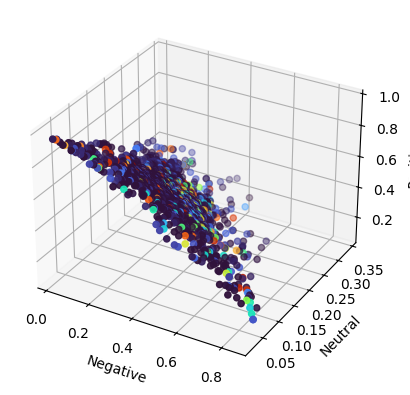

In [162]:
append_cluster_color(url_clustering_3, "group_id")
get_cluster_plot(url_clustering_3, "group_id")

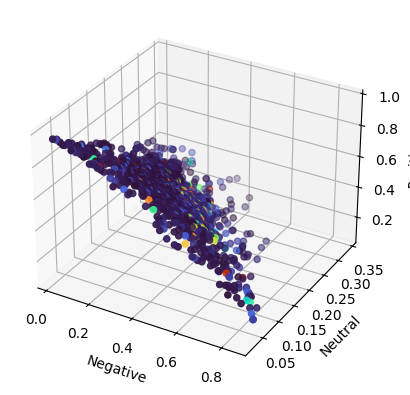

In [166]:
append_cluster_color(url_clustering_2, "group_id")
get_cluster_plot(url_clustering_2, "group_id")

In [61]:
# for name in coefficient_names:
#     url_clustering_2.rename(columns={name: f"avg_{name}"}, inplace=True)
df.columns

Index(['url', 'pagetitle', 'avg_negative', 'avg_neutral', 'avg_positive',
       'color', 'text', 'linkedpages', 'url_elements_list', 'group_id',
       'color_group_id'],
      dtype='object')

In [92]:
import pandas as pd

# Annahme, dass 'df' Ihr ursprünglicher DataFrame ist
coefficient_names = ["negative", "neutral", "positive"]

# Standardabweichung für die Koeffizienten berechnen
std_dev = df.groupby("group_id")[coefficient_names].std()
usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"] != 0)]

# Anzahl der Elemente in jedem Cluster berechnen
cluster_sizes = df.groupby("group_id").size()

# Durchschnittswerte für die Koeffizienten in den verwendbaren Gruppen berechnen
mean_coeffs = df[df["group_id"].isin(usable_values.index)].groupby("group_id")[coefficient_names].mean()

# Die Anzahl der Elemente pro Cluster zum DataFrame der Durchschnittswerte hinzufügen
mean_coeffs['count'] = cluster_sizes

# Die Spalten umbenennen, um konsistente und klare Namen zu verwenden
mean_coeffs.rename(columns={name: f"avg_{name[:3]}" for name in coefficient_names}, inplace=True)

# Das resultierende DataFrame anzeigen oder weiter verwenden
print(mean_coeffs)


           avg_neg   avg_neu   avg_pos  count
group_id                                     
1         0.431127  0.171856  0.397017     97
3         0.390685  0.170080  0.439235     52
5         0.354308  0.184521  0.461171     10
6         0.433656  0.161298  0.405045     32
7         0.397984  0.155039  0.446977    195
8         0.461505  0.109460  0.429035      8
9         0.364746  0.161259  0.473995     26
10        0.345667  0.117823  0.536510    257
11        0.265757  0.134153  0.600090     49
12        0.303153  0.148598  0.548249    527
13        0.283021  0.152845  0.564135    253
14        0.413754  0.167559  0.418687      4
15        0.381694  0.155658  0.462648     64
25        0.367355  0.141502  0.491142     18
59        0.283038  0.200564  0.516398      2
85        0.262948  0.180709  0.556343      6
91        0.173873  0.100554  0.725573      4
94        0.386608  0.179062  0.434330     11


In [115]:
df =  pd.read_json("../sentiment-analyser/url_clustering_2_02-05-24.json")




In [119]:
get_average_sentiment_and_size_per_cluster(df, "cluster_id")

,avg_neg,avg_neu,avg_pos,cluster_size
group_id,,,,
1,0.431127,0.171856,0.397017,97
3,0.390685,0.170080,0.439235,52
5,0.354308,0.184521,0.461171,10
6,0.433656,0.161298,0.405045,32
7,0.397984,0.155039,0.446977,195
8,0.461505,0.109460,0.429035,8
9,0.364746,0.161259,0.473995,26
10,0.345667,0.117823,0.536510,257
11,0.265757,0.134153,0.600090,49


In [83]:
url_clustering_2[url_clustering_2["group_id"]==5]

,url,pagetitle,negative,neutral,positive,color,text,linkedpages,url_elements_list,group_id,color_group_id
18,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutz,0.213850,0.202380,0.583770,#6ac800,Datenschutz,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
61,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für den Mobiliar Ticketshop,0.299267,0.205337,0.495396,#80b200,Datenschutzerklärung für den Mobiliar Ticketsh...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
63,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für Mietverträge,0.355692,0.175499,0.468810,#87a400,Datenschutzerklärung für Mietverträge In de...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
880,https://www.mobiliar.ch/versicherungen-und-vor...,Vertrauliche E-Mail-Kommunikation,0.436349,0.189960,0.373692,#9f8f00,Vertrauliche E-Mail-Kommunikation Auf meinem A...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
891,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung zum Bewerbungsverfahren,0.394098,0.186404,0.419497,#949a00,Datenschutzerklärung zum Bewerbungsverfahren ...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
912,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für Hypotheken,0.390487,0.165614,0.443899,#8d9b00,Datenschutzerklärung für Hypotheken In der ...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
921,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für Anlagefonds,0.346447,0.167776,0.485777,#83a600,Datenschutzerklärung für Anlagefonds In der...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
928,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für die Schadenfallbearbe...,0.423968,0.172021,0.404011,#979200,Datenschutzerklärung für die Schadenfallbearbe...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
936,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für Versicherungsverträge,0.323304,0.180773,0.495923,#80ac00,Datenschutzerklärung für Versicherungsverträge...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."
1033,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutzerklärung für Internetseiten,0.359616,0.199451,0.440933,#8ea300,Datenschutzerklärung für Internetseiten 1. Gel...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",5,"[0.27103000000000005, 0.35926, 0.8115600000000..."


In [2]:
import pandas as pd
url_clustering_2 = pd.read_json("../graph_network/url_clustering_2_04-05-24.json")

In [17]:
append_mean_coefficients_per_cluster(url_clustering_2, "group_id")

,url,pagetitle,negative,neutral,positive,color,text,linkedpages,url_elements_list,group_id,color_group_id,avg_group_neg,avg_group_neu,avg_group_pos
0,https://www.mobiliar.ch,Versicherungen & Vorsorge,0.230486,0.140164,0.629349,#5ec400,Versicherungen & Vorsorge,[https://www.mobiliar.ch/versicherungen-und-vo...,[www.mobiliar.ch],1,#ff0000,0.230486,0.140164,0.629349
1,https://www.mobiliar.ch/versicherungen-und-vor...,Tierversicherung,0.461594,0.169703,0.368704,#a08900,Tierversicherung Hunde und Katzen versichern V...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",2,#f5a505,0.431127,0.171856,0.397017
2,https://www.mobiliar.ch/versicherungen-und-vor...,Cyberversicherung,0.439090,0.151812,0.409098,#968f00,Cyberversicherung Hilfe im digitalen Alltag Ih...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",2,#f5a505,0.431127,0.171856,0.397017
3,https://www.mobiliar.ch/versicherungen-und-vor...,Hypotheken – Ihr Schlüssel zum Eigenheim,0.469653,0.252989,0.277358,#b88700,Hypotheken – Ihr Schlüssel zum Eigenheim Eigen...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",2,#f5a505,0.431127,0.171856,0.397017
4,https://www.mobiliar.ch/versicherungen-und-vor...,Mietkautionsversicherung,0.329905,0.199418,0.470677,#86aa00,Mietkautionsversicherung Dank einer Mietkautio...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",2,#f5a505,0.431127,0.171856,0.397017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1741,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Verwaltungsrat,0.234636,0.228402,0.536962,#76c300,Verwaltungsrat,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, ueber-uns, ges...",14,#f50515,0.283021,0.152845,0.564135
1742,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Chaire Mobilière EPFL,0.320294,0.160859,0.518848,#7aad00,Chaire Mobilière EPFL \n\tFast die Hälfte d...,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, ueber-uns, ges...",14,#f50515,0.283021,0.152845,0.564135
1743,https://www.mobiliar.ch/die-mobiliar/ueber-uns...,Wertschöpfungsrechnung,0.188053,0.175418,0.636528,#5ccf00,Wertschöpfungsrechnung \n\tDie Wertschöpfun...,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, ueber-uns, ges...",14,#f50515,0.283021,0.152845,0.564135
1744,https://www.mobiliar.ch/die-mobiliar/nachhalti...,Bewilligte Projekte,0.251427,0.199767,0.548806,#73be00,Bewilligte Projekte Der Fonds der Mobiliar ...,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, nachhaltigkeit...",11,#05f531,0.345667,0.117823,0.536510


In [16]:
append_mean_coefficients_per_cluster(url_clustering_2, "group_id")[
    [
        "negative",
        "neutral",
        "positive",
        "avg_cluster_negative",
        "avg_cluster_neutral",
        "avg_cluster_positive",
    ]
].corr()[["negative", "neutral", "positive"]][3:6]

KeyError: "['avg_cluster_negative', 'avg_cluster_neutral', 'avg_cluster_positive'] not in index"

In [27]:
def get_correlation_df_per_cluster(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]

    std_dev = df.groupby("group_id")[coefficient_names].std()
    usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"]!=0)]

    mean_coeffs = df[df["group_id"].isin(usable_values.index)].groupby("group_id")[coefficient_names].mean().reset_index()

    correlation_matrix_per_cluster = df[df["group_id"].isin(usable_values.index)][["group_id", "negative", "neutral", "positive"]].groupby("group_id")[coefficient_names].corr()

    for name in coefficient_names:
        mean_coeffs.rename(columns={name: f"avgc_{name}"}, inplace=True)
    correlation_of_mean_sentiment_per_cluster = mean_coeffs[["avgc_negative", "avgc_neutral", "avgc_positive"]].corr() 
        
    return correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster


correlation_of_mean_sentiment_per_cluster, correlation_matrix_per_cluster = get_correlation_df_per_cluster(url_clustering_2, "group_id")
correlation_of_mean_sentiment_per_cluster
correlation_matrix_per_cluster

negative   neutral  positive
group_id                                       
1        negative  1.000000 -0.423196 -0.955775
         neutral  -0.423196  1.000000  0.138015
         positive -0.955775  0.138015  1.000000
3        negative  1.000000  0.030561 -0.956925
         neutral   0.030561  1.000000 -0.319445
         positive -0.956925 -0.319445  1.000000
5        negative  1.000000 -0.513035 -0.977507
         neutral  -0.513035  1.000000  0.320465
         positive -0.977507  0.320465  1.000000
6        negative  1.000000 -0.490303 -0.956215
         neutral  -0.490303  1.000000  0.213762
         positive -0.956215  0.213762  1.000000
7        negative  1.000000 -0.186736 -0.942200
         neutral  -0.186736  1.000000 -0.153213
         positive -0.942200 -0.153213  1.000000
8        negative  1.000000  0.176086 -0.980876
         neutral   0.176086  1.000000 -0.364312
         positive -0.980876 -0.364312  1.000000
9        negative  1.000000 -0.023037 -0.894194
         neutral  -0.023037  1.000000 -0.426960
         positive -0.894194 -0.426960  1.000000
10       negative  1.000000 -0.048954 -0.976020
         neutral  -0.048954  1.000000 -0.169639
         positive -0.976020 -0.169639  1.000000
11       negative  1.000000  0.169073 -0.893490
         neutral   0.169073  1.000000 -0.593683
         positive -0.893490 -0.593683  1.000000
12       negative  1.000000  0.284982 -0.954097
         neutral   0.284982  1.000000 -0.558978
         positive -0.954097 -0.558978  1.000000
13       negative  1.000000  0.269851 -0.936971
         neutral   0.269851  1.000000 -0.589288
         positive -0.936971 -0.589288  1.000000
14       negative  1.000000  0.546205 -0.978541
         neutral   0.546205  1.000000 -0.707083
         positive -0.978541 -0.707083  1.000000
15       negative  1.000000 -0.108615 -0.954144
         neutral  -0.108615  1.000000 -0.193944
         positive -0.954144 -0.193944  1.000000
25       negative  1.000000  0.224778 -0.975334
         neutral   0.224778  1.000000 -0.434321
         positive -0.975334 -0.434321  1.000000
59       negative  1.000000 -1.000000  1.000000
         neutral  -1.000000  1.000000 -1.000000
         positive  1.000000 -1.000000  1.000000
85       negative  1.000000 -0.157282 -0.866976
         neutral  -0.157282  1.000000 -0.355788
         positive -0.866976 -0.355788  1.000000
91       negative  1.000000  0.783904 -0.991871
         neutral   0.783904  1.000000 -0.856539
         positive -0.991871 -0.856539  1.000000
94       negative  1.000000  0.530373 -0.984354
         neutral   0.530373  1.000000 -0.671454
         positive -0.984354 -0.671454  1.000000

In [25]:
def get_correlation_df_per_cluster(df, cluster_col):
    # Spaltennamen der Koeffizienten
    coefficient_names = ["negative", "neutral", "positive"]

    # Berechnen der Standardabweichung für jede group_id
    std_dev = df.groupby(cluster_col)[coefficient_names].std()

    # Filtern der Datensätze, wo neutrale Koeffizienten nicht null sind und vorhanden
    usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"] != 0)]

    # Berechnen des Mittelwerts der Koeffizienten für die benutzbaren Gruppen
    mean_coeffs = df[df[cluster_col].isin(usable_values.index)].groupby(cluster_col)[coefficient_names].mean().reset_index()

    # Umbenennen der Mittelwerte für die Klarheit in der Ausgabe
    mean_coeffs.rename(columns={"negative": "avg_neg", "neutral": "avg_neu", "positive": "avg_pos"}, inplace=True)

    # Anfügen der Durchschnittswerte an den DataFrame, der durch die Gruppierung entsteht
    # Hinweis: Es wird angenommen, dass die ursprünglichen Daten die 'group_id' als separate Spalte enthalten.
    # Falls nicht, sollten Sie den DataFrame entsprechend Ihrer spezifischen Datenstruktur anpassen.
    result_df = df.groupby(cluster_col).first().reset_index().merge(mean_coeffs, on=cluster_col, how="left")

    return result_df[result_df[cluster_col].isin(usable_values.index)]

df = get_correlation_df_per_cluster(url_clustering_2, "group_id")
df#.corr(method="pearson", numeric_only=True)


,group_id,url,pagetitle,negative,neutral,positive,color,text,linkedpages,url_elements_list,color_group_id,avg_neg,avg_neu,avg_pos
1,1,https://www.mobiliar.ch/versicherungen-und-vor...,Tierversicherung,0.461594,0.169703,0.368704,#a08900,Tierversicherung Hunde und Katzen versichern V...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.225, 0.16354000000000002, 0.45096, 1.0]",0.431127,0.171856,0.397017
3,3,https://www.mobiliar.ch/versicherungen-und-vor...,Reiseversicherung,0.365522,0.160471,0.474007,#86a100,Reiseversicherung Rundumschutz mit Annullation...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.23915000000000003, 0.20833000000000002, 0.5...",0.390685,0.170080,0.439235
5,5,https://www.mobiliar.ch/versicherungen-und-vor...,Datenschutz,0.213850,0.202380,0.583770,#6ac800,Datenschutz,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.27103000000000005, 0.35926, 0.8115600000000...",0.354308,0.184521,0.461171
6,6,https://www.mobiliar.ch/versicherungen-und-vor...,Die «Meine Mobiliar» App,0.387417,0.156415,0.456168,#8a9c00,Die «Meine Mobiliar» App Ihre Versicherung in ...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.25107, 0.25237000000000004, 0.6337400000000...",0.433656,0.161298,0.405045
7,7,https://www.mobiliar.ch/versicherungen-und-vor...,Was tun bei einem Cyberangriff?,0.477410,0.221592,0.300998,#b28500,Was tun bei einem Cyberangriff? Ihre Checklis...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.21708000000000002, 0.14087000000000002, 0.3...",0.397984,0.155039,0.446977
8,8,https://www.mobiliar.ch/versicherungen-und-vor...,Willkommen daheim!,0.079039,0.035234,0.885728,#1dea00,"Willkommen daheim! Es ist ein langer Weg, b...","[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.27334, 0.38008000000000003, 0.8403700000000...",0.461505,0.109460,0.429035
9,9,https://www.mobiliar.ch/versicherungen-und-vor...,Alles für Ihr KMU,0.443824,0.064128,0.492048,#818d00,Alles für Ihr KMU Umfassend versichert und run...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...","[0.25618, 0.27412000000000003, 0.67381, 1.0]",0.364746,0.161259,0.473995
10,10,https://www.mobiliar.ch/die-mobiliar/nachhalti...,Unser Nachhaltigkeitsansatz,0.518506,0.056750,0.424744,#927a00,Unser Nachhaltigkeitsansatz Engagiert für die ...,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, nachhaltigkeit...","[0.19956000000000002, 0.09498000000000001, 0.2...",0.345667,0.117823,0.536510
11,11,https://www.mobiliar.ch/die-mobiliar/karriere,Jobs und Karriere bei der Mobiliar,0.425336,0.075343,0.499320,#7f9200,Jobs und Karriere bei der Mobiliar Spannende J...,"[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, karriere]","[0.24539000000000002, 0.23044, 0.5914200000000...",0.265757,0.134153,0.600090
12,12,https://www.mobiliar.ch/die-mobiliar/medien,Medien,0.313902,0.195735,0.490363,#81ae00,"Medien \n\tMedienmitteilungen, Kontakt für ...","[https://www.mobiliar.ch/die-mobiliar, https:/...","[www.mobiliar.ch, die-mobiliar, medien]","[0.18995, 0.07176, 0.23217000000000002, 1.0]",0.303153,0.148598,0.548249


In [38]:
def get_correlation_df_per_cluster(df, cluster_col):
    # Spaltennamen der Koeffizienten
    coefficient_names = ["negative", "neutral", "positive"]

    # Erstellen eines leeren DataFrames für das Endergebnis
    result_df = pd.DataFrame()
    
    std_dev = df.groupby(cluster_col)[coefficient_names].std()
    # Filtern der Datensätze, wo neutrale Koeffizienten nicht null sind und vorhanden
    usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"] != 0)]
    filtered_df = df[df[cluster_col].isin(usable_values.index)]
    # Durchlaufen aller Gruppen und Berechnen der Durchschnittswerte
    for group_id in filtered_df[cluster_col].unique():
        # Filtern der Daten für die aktuelle group_id
        group_data = filtered_df[filtered_df[cluster_col] == group_id]

        # Berechnen des Mittelwerts für die Gruppe
        mean_values = group_data[coefficient_names].mean()

        # Erstellen von Spaltennamen basierend auf der group_id
        for col in coefficient_names:
            result_df[f'avg_{col[:3]}_{group_id}'] = [mean_values[col]]

    return result_df

df = get_correlation_df_per_cluster(url_clustering_2, "group_id")
df#.corr(method="pearson")

,avg_neg_1,avg_neu_1,avg_pos_1,avg_neg_3,avg_neu_3,avg_pos_3,avg_neg_5,avg_neu_5,avg_pos_5,avg_neg_6,...,avg_pos_85,avg_neg_25,avg_neu_25,avg_pos_25,avg_neg_91,avg_neu_91,avg_pos_91,avg_neg_94,avg_neu_94,avg_pos_94
0,0.431127,0.171856,0.397017,0.390685,0.17008,0.439235,0.354308,0.184521,0.461171,0.433656,...,0.556343,0.367355,0.141502,0.491142,0.173873,0.100554,0.725573,0.386608,0.179062,0.43433


In [37]:
url_clustering_2

coefficient_names = ["negative", "neutral", "positive"]

# Erstellen eines leeren DataFrames für das Endergebnis
result_df = pd.DataFrame()

std_dev = url_clustering_2.groupby("group_id")[coefficient_names].std()
# Filtern der Datensätze, wo neutrale Koeffizienten nicht null sind und vorhanden
usable_values = std_dev[(std_dev["neutral"].notnull()) & (std_dev["neutral"] != 0)]
filtered_df = url_clustering_2[url_clustering_2["group_id"].isin(usable_values.index)]
filtered_df[filtered_df["group_id"]==1]#.corr(method="pearson", numeric_only=True)

,url,pagetitle,negative,neutral,positive,color,text,linkedpages,url_elements_list,group_id,color_group_id
1,https://www.mobiliar.ch/versicherungen-und-vor...,Tierversicherung,0.461594,0.169703,0.368704,#a08900,Tierversicherung Hunde und Katzen versichern V...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
2,https://www.mobiliar.ch/versicherungen-und-vor...,Cyberversicherung,0.439090,0.151812,0.409098,#968f00,Cyberversicherung Hilfe im digitalen Alltag Ih...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
3,https://www.mobiliar.ch/versicherungen-und-vor...,Hypotheken – Ihr Schlüssel zum Eigenheim,0.469653,0.252989,0.277358,#b88700,Hypotheken – Ihr Schlüssel zum Eigenheim Eigen...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
4,https://www.mobiliar.ch/versicherungen-und-vor...,Mietkautionsversicherung,0.329905,0.199418,0.470677,#86aa00,Mietkautionsversicherung Dank einer Mietkautio...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
5,https://www.mobiliar.ch/versicherungen-und-vor...,Der Privat-Rechtsschutz,0.409113,0.188124,0.402763,#989600,Der Privat-Rechtsschutz Schutz vor hohen Recht...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
...,...,...,...,...,...,...,...,...,...,...,...
986,https://www.mobiliar.ch/versicherungen-und-vor...,Wie Sie die Versicherungssumme Hausrat berechnen,0.310267,0.164561,0.525172,#79af00,Wie Sie die Versicherungssumme Hausrat berechn...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
999,https://www.mobiliar.ch/versicherungen-und-vor...,Liiva,0.313402,0.155001,0.531597,#77af00,Liiva Sie möchten Ihrem eigenen Wohntraum n...,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
1004,https://www.mobiliar.ch/versicherungen-und-vor...,Offertanfrage Haustierversicherung,0.306248,0.196371,0.497381,#80b000,Offertanfrage Haustierversicherung,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"
1008,https://www.mobiliar.ch/versicherungen-und-vor...,Offertanfrage Haustierversicherung,0.306248,0.196371,0.497381,#80b000,Offertanfrage Haustierversicherung,"[https://www.mobiliar.ch/, https://www.mobilia...","[www.mobiliar.ch, versicherungen-und-vorsorge,...",1,"[0.225, 0.16354000000000002, 0.45096, 1.0]"


In [100]:
a = url_clustering_2["group_id"]==url_clustering_3["group_id"]
a.value_counts()

group_id
False    1713
True       33
Name: count, dtype: int64

In [343]:
senti[senti["group_id"]==95]

,url,pagetitle,negative,neutral,positive,color,text,linkedpages,url_elements_list,group_id
956,https://secure.mobiliar.ch/praemienrechner/casa-init?bedarf=802752&language=de,,0.255851,0.243741,0.500408,#7fbd00,,[],"[secure.mobiliar.ch, praemienrechner, casa-init]",95
957,https://secure.mobiliar.ch/praemienrechner/casa-init?language=de,,0.255851,0.243741,0.500408,#7fbd00,,[],"[secure.mobiliar.ch, praemienrechner, casa-init]",95


In [301]:
def calculate_within_cluster_variance(df, cluster_col):
    coefficient_names = ["negative", "neutral", "positive"]
    variances = df.groupby(cluster_col)[coefficient_names].var()
    return variances

variances = calculate_within_cluster_variance(senti, 'group_id')
print(variances)

          negative   neutral  positive
group_id                              
0              NaN       NaN       NaN
1         0.009338  0.000823  0.007814
2              NaN       NaN       NaN
3         0.008721  0.000819  0.009704
4              NaN       NaN       NaN
...            ...       ...       ...
1422           NaN       NaN       NaN
1525           NaN       NaN       NaN
1680           NaN       NaN       NaN
1681           NaN       NaN       NaN
1693           NaN       NaN       NaN

[125 rows x 3 columns]


In [288]:
get_mean_coefficients_per_cluster(senti, "group_id")

Cluster Nr. 0; Total Pages in Cluster: 1
avg negative: 0.23049
avg neutral: 0.14016
avg positive: 0.62935

Cluster Nr. 1; Total Pages in Cluster: 97
avg negative: 0.43113
avg neutral: 0.17186
avg positive: 0.39702

Cluster Nr. 2; Total Pages in Cluster: 1
avg negative: 0.41703
avg neutral: 0.11462
avg positive: 0.46834

Cluster Nr. 3; Total Pages in Cluster: 52
avg negative: 0.39068
avg neutral: 0.17008
avg positive: 0.43924

Cluster Nr. 4; Total Pages in Cluster: 1
avg negative: 0.4285
avg neutral: 0.20728
avg positive: 0.36422

Cluster Nr. 5; Total Pages in Cluster: 10
avg negative: 0.35431
avg neutral: 0.18452
avg positive: 0.46117

Cluster Nr. 6; Total Pages in Cluster: 32
avg negative: 0.43366
avg neutral: 0.1613
avg positive: 0.40505

Cluster Nr. 7; Total Pages in Cluster: 195
avg negative: 0.39798
avg neutral: 0.15504
avg positive: 0.44698

Cluster Nr. 8; Total Pages in Cluster: 8
avg negative: 0.46151
avg neutral: 0.10946
avg positive: 0.42903

Cluster Nr. 9; Total Pages in Clu

## Word-Clouds

In [59]:
senti['word_count'] = senti['text'].apply(lambda x: len(str(x).split()))

In [45]:
def clean_url(url):
    if 'mobiliar.ch' in url:
        return url.replace('https://www.mobiliar.ch', '').lstrip('/').replace('/', ', ')
        # if "die-mobiliar" in url:
        #     return url.replace('die-mobiliar', '').lstrip('/').replace('/', ', ')
    return url.replace('/', ', ')

# Anwenden der Funktion auf die 'url'-Spalte und Erstellen einer neuen Spalte
senti['cleaned_url'] = senti['url'].apply(clean_url)

In [90]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [109]:
text = senti.drop_duplicates(subset=['text', "negative", "neutral", "positive"]).sort_values("positive", ascending=False)[:25]["text"].str.cat(sep=" ")

# text = senti.loc[senti["cluster"]==2]["text"].str.cat(sep=" ")
print ("There are {} words.".format(len(text)))

There are 22686 words.


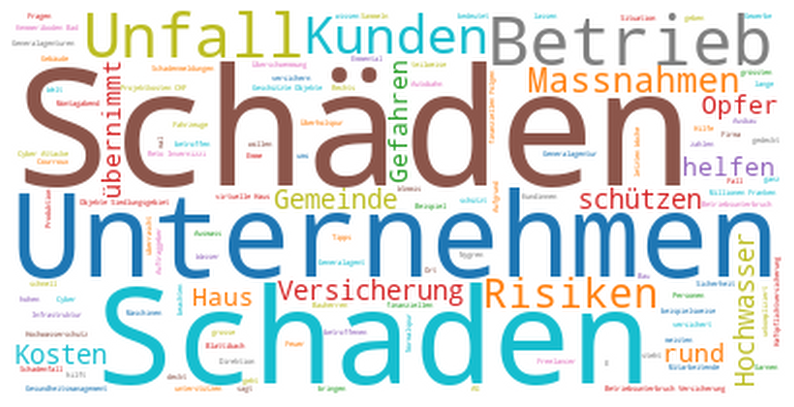

In [108]:
stop_words = []
with open("../sentiment-analyser/german_stopwords.txt", 'r', encoding='utf-8') as file:
    content = file.read()
    stop_words = [word.strip() for word in content.split(',')]

stopwords = set(STOPWORDS)
stopwords.update(stop_words + ["mobiliar", "z.B.", "jQuery", "getScript", "hasJquery", "function", "undefined", "letTimeout"])

wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="tab10").generate(text)

plt.figure(figsize=[10,10])
plt.imshow(wordcloud, interpolation='lanczos')
plt.axis("off")
plt.show()

In [32]:
# Save the image in the img folder:
wordcloud.to_file("wordcloud_cluster_bad.png")

In [ ]:
senti.drop_duplicates(subset=['text', "negative", "neutral", "positive"]).sort_values("negative", ascending=False)[:10]#["url"]


In [ ]:
 #.loc[senti["cluster"]==3]
senti.sort_values("negative", ascending=False)[:10]#["url"]

